# Modelling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE

In [3]:
#train_comb = pd.read_csv('../assets/train_comb.csv')

In [4]:
#train_comb['date'] = pd.to_datetime(train_comb['date'])
#train_comb.set_index('date', inplace=True)

In [5]:
# dropping trap column for now as it is not numeralize yet
#X = train_comb.drop(columns=['wnvpresent', 'trap'])
#y = train_comb['wnvpresent']

In [6]:
# Scale X data
#ss = StandardScaler()
#Xs_train, Xs_val = ss.fit_transform(X_train), ss.transform(X_val)

In [7]:
def append_results(result, train_score, metric, classifier):
    tmp = pd.DataFrame({
        'model':classifier,
        'train_accuracy': train_score,
        'test_accuracy': metric[metric['metric'] == 'accuracy']['score'].values[0],
        'misclassification': metric[metric['metric'] == 'misclassification_rate']['score'].values[0],
        'sensitivity': metric[metric['metric'] == 'sensitivity']['score'].values[0],
        'specificity': metric[metric['metric'] == 'specificity']['score'].values[0],
        'precision': metric[metric['metric'] == 'precision']['score'].values[0],
        'f1_score': metric[metric['metric'] == 'f1_score']['score'].values[0],
        'roc_auc':metric[metric['metric'] == 'roc_auc']['score'].values[0],
        #'misclassed_data':misclass_data
    }, index=[0])
    result = pd.concat([result,tmp], axis=0, ignore_index=True)
    return result

In [8]:
def metrics_and_plot_cm(classifier, X, y):
    preds = classifier.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
    acc = (tp + tn) / (tn + fp + fn + tp)
    misclass = 1 - acc
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    f_one_score = f1_score(y, preds)
    roc_auc = roc_auc_score(y, classifier.predict_proba(X)[:,1])
    results = {
        'accuracy': acc,
        'misclassification_rate': misclass,
        'sensitivity': sens,
        'specificity': spec,
        'precision': prec,
        'f1_score':f_one_score,
        'roc_auc':roc_auc
    }
    fig, axes = plt.subplots(ncols=2, figsize=(13,5))
    cm_chart = plot_confusion_matrix(classifier, X, y, cmap='Blues', values_format='d',display_labels=['WNV Present (1)','WNV Not Present (0)'], ax=axes[0]);
    roc_curve = plot_roc_curve(classifier, X, y, ax=axes[1])
    axes[1].plot([0, 1], [0, 1], label='baseline', linestyle='--' )
    metrics = pd.DataFrame({
        'metric': results.keys(),
        'score': results.values()
        })
    return metrics

In [9]:
X_train = pd.read_csv('../assets/X_train.csv')
y_train = pd.read_csv('../assets/y_train.csv')

In [10]:
X_train.head()

,Unnamed: 0,depart,dewpoint,wetbulb,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,...,month_8,month_9,month_10,br,dz,fg,hz,ra,ts,vcts
0,0,1.148877,-0.172283,0.113218,-0.394225,1.181543,1.189627,-0.072273,0.022267,-0.380512,...,0.0,0.0,0.0,1,0,0,1,0,0,0
1,1,1.148877,-0.172283,0.113218,-0.394225,1.181543,1.189627,-0.072273,0.022267,-0.380512,...,0.0,0.0,0.0,1,0,0,1,0,0,0
2,2,1.148877,-0.172283,0.113218,-0.394225,1.181543,1.189627,-0.072273,0.022267,-0.380512,...,0.0,0.0,0.0,1,0,0,1,0,0,0
3,3,1.148877,-0.172283,0.113218,-0.394225,1.181543,1.189627,-0.072273,0.022267,-0.380512,...,0.0,0.0,0.0,1,0,0,1,0,0,0
4,4,1.148877,-0.172283,0.113218,-0.394225,1.181543,1.189627,-0.072273,0.022267,-0.380512,...,0.0,0.0,0.0,1,0,0,1,0,0,0


In [11]:
X_train.drop(columns='Unnamed: 0', inplace=True)

In [12]:
X_train.shape

(8304, 89)

In [13]:
y_train.head()

,date,wnvpresent
0,2007-05-29,0
1,2007-05-29,0
2,2007-05-29,0
3,2007-05-29,0
4,2007-05-29,0


In [14]:
y_train = y_train['wnvpresent']

In [15]:
y_train.shape

(8304,)

In [16]:
# train/test split on data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

## Baseline Score

In [17]:
y_train.value_counts(normalize=True)

0    0.944926
1    0.055074
Name: wnvpresent, dtype: float64

The baseline accuracy score would be 0.948.

In [18]:
results_df = pd.DataFrame(columns=[
    'model',
    'train_accuracy',
    'test_accuracy',
    'misclassification',
    'sensitivity',
    'specificity',
    'precision',
    'f1_score',
    'roc_auc'
])

## Account for Imbalanced Class

We note from our target column: 'wnvpresent' that there is massive class imbalance. We can resolve this by using SMOTE and embed it within a pipeline.

## Logistic Regression

In [19]:
# instantiate pipeline
pipe_logreg = Pipeline([('sampling', SMOTE()),
                ('logreg', LogisticRegression(solver='liblinear', random_state=42))
                ])

In [20]:
# set params to gridsearch
# sampling params set to comment because it was taking too long to fit
pipe_logreg_params = {
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C': [1], #0.5, 1, 1.5
    'sampling__sampling_strategy': ['not minority'], # auto, minority
    'sampling__k_neighbors': [9, 11, 13],  #3, 5, 7, 9, 13, 15
}

In [21]:
gs_logreg = GridSearchCV(pipe_logreg, pipe_logreg_params, verbose=2, n_jobs=-1)

In [22]:
%%time
gs_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Wall time: 5.28 s


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()),
                                       ('logreg',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [1], 'logreg__penalty': ['l1', 'l2'],
                         'sampling__k_neighbors': [9, 11, 13],
                         'sampling__sampling_strategy': ['not minority']},
             verbose=2)

In [23]:
gs_logreg.best_params_

{'logreg__C': 1,
 'logreg__penalty': 'l1',
 'sampling__k_neighbors': 9,
 'sampling__sampling_strategy': 'not minority'}

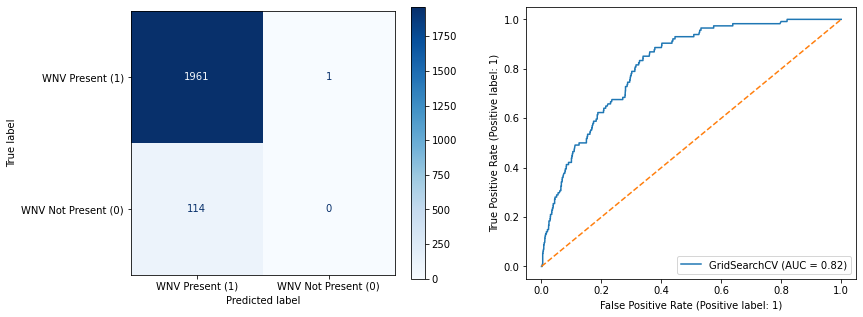

In [24]:
mod_metrics = metrics_and_plot_cm(gs_logreg, X_val, y_val)

In [25]:
results_df = append_results(results_df,
                           gs_logreg.score(X_train, y_train),
                           mod_metrics,
                           'Logistic Regression',
                           )

In [26]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
0,Logistic Regression,0.944926,0.944605,0.055395,0.0,0.99949,0.0,0.0,0.816471


## SVM

In [27]:
# instantiate pipeline
pipe_svc = Pipeline([('sampling', SMOTE()),
                 ('svc', SVC(probability=True, random_state=100)) # probability=True is needed to calculate predict_proba 
                ])

In [28]:
pipe_svc_params = {
    'svc__C': [7], #5, 9
    'svc__kernel': ['rbf', 'poly'],  
    'sampling__sampling_strategy': ['not minority'], #auto
    'sampling__k_neighbors': [3], #5     
}

In [29]:
gs_svc = GridSearchCV(pipe_svc, pipe_svc_params, verbose=2, n_jobs=-1)

In [30]:
%%time
gs_svc.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 27.3 s


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=100))]),
             n_jobs=-1,
             param_grid={'sampling__k_neighbors': [3],
                         'sampling__sampling_strategy': ['not minority'],
                         'svc__C': [7], 'svc__kernel': ['rbf', 'poly']},
             verbose=2)

In [31]:
gs_svc.best_params_

{'sampling__k_neighbors': 3,
 'sampling__sampling_strategy': 'not minority',
 'svc__C': 7,
 'svc__kernel': 'rbf'}

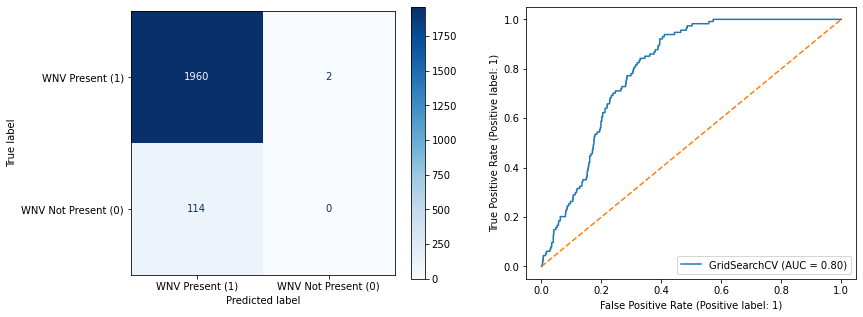

In [32]:
mod_metrics = metrics_and_plot_cm(gs_svc, X_val, y_val)

In [33]:
results_df = append_results(results_df,
                           gs_svc.score(X_train, y_train),
                           mod_metrics,
                           'SVM',
                           )

In [34]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
0,Logistic Regression,0.944926,0.944605,0.055395,0.0,0.999490,0.0,0.0,0.816471
1,SVM,0.946050,0.944123,0.055877,0.0,0.998981,0.0,0.0,0.803025


## PCA

In [35]:
# instantiate pca
pca = PCA(random_state=42)

In [36]:
pca.fit(X_train)

PCA(random_state=42)

In [37]:
Z_train, Z_val = pca.transform(X_train), pca.transform(X_val)

In [38]:
pca.explained_variance_ratio_.round(3)

array([0.323, 0.169, 0.085, 0.069, 0.067, 0.064, 0.048, 0.028, 0.019,
       0.015, 0.01 , 0.008, 0.006, 0.006, 0.006, 0.005, 0.004, 0.004,
       0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [39]:
comp_10 = pca.explained_variance_ratio_.round(3)[:10].sum()
print(f'We see that the first 10 components explain {comp_10*100} % of the variance')

We see that the first 10 components explain 88.7 % of the variance


In [40]:
comp_30 = pca.explained_variance_ratio_.round(3)[:30].sum()
print(f'We see that the first 30 components explain {comp_30*100} % of the variance')

We see that the first 30 components explain 96.2 % of the variance


### Logistic Regression with PCA

In [41]:
# embed pca in a pipeline
pipe_pca_logreg = Pipeline([('sampling', SMOTE()),
                 ('pca', PCA()),
                 ('logreg', LogisticRegression(solver='liblinear', random_state=42))
                ])

In [42]:
pipe_pca_logreg_params = {
    'logreg__penalty': ['l1', 'l2'], 
    'logreg__C': [0.1, 0.5, 1],  #1.5, 2
    'pca__n_components': [10, 15],  #20, 30, 40
    'sampling__sampling_strategy': ['not minority'],  #auto, minority
    'sampling__k_neighbors': [1, 3, 5],  #5
}

In [43]:
gs_pca_logreg = GridSearchCV(pipe_pca_logreg, pipe_pca_logreg_params, verbose=2, n_jobs=-1)

In [44]:
%%time
gs_pca_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Wall time: 4.68 s


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()), ('pca', PCA()),
                                       ('logreg',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.1, 0.5, 1],
                         'logreg__penalty': ['l1', 'l2'],
                         'pca__n_components': [10, 15],
                         'sampling__k_neighbors': [1, 3, 5],
                         'sampling__sampling_strategy': ['not minority']},
             verbose=2)

In [45]:
gs_pca_logreg.best_params_

{'logreg__C': 0.1,
 'logreg__penalty': 'l1',
 'pca__n_components': 10,
 'sampling__k_neighbors': 1,
 'sampling__sampling_strategy': 'not minority'}

<ipython-input-8-04f0a039b628>:8: RuntimeWarning: invalid value encountered in longlong_scalars
  prec = tp / (tp + fp)


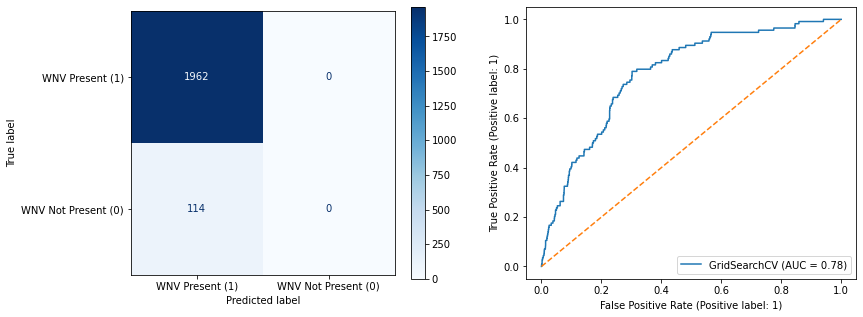

In [46]:
mod_metrics = metrics_and_plot_cm(gs_pca_logreg, X_val, y_val)

In [47]:
results_df = append_results(results_df,
                           gs_pca_logreg.score(X_train, y_train),
                           mod_metrics,
                           'PCA Logistic Regression',
                           )

In [48]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
0,Logistic Regression,0.944926,0.944605,0.055395,0.0,0.999490,0.0,0.0,0.816471
1,SVM,0.946050,0.944123,0.055877,0.0,0.998981,0.0,0.0,0.803025
2,PCA Logistic Regression,0.944926,0.945087,0.054913,0.0,1.000000,NaN,0.0,0.783228


### SVM with PCA

In [49]:
pipe_pca_svc = Pipeline([('sampling', SMOTE()),
                 ('pca', PCA()),
                 ('svc', SVC(probability=True, random_state=42))
])

In [50]:
pipe_pca_svc_params = {
    'svc__C': [5, 7], # 5, 9
    'svc__kernel': ['rbf'], #'poly' 
    'pca__n_components': [10, 20],   #20, 30
    'sampling__sampling_strategy': ['not minority'], #auto
    'sampling__k_neighbors': [1, 3],  #5    
}

In [51]:
gs_pca_svc = GridSearchCV(pipe_pca_svc, pipe_pca_svc_params, verbose=2, n_jobs=-1)

In [52]:
%%time
gs_pca_svc.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Wall time: 38.8 s


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()), ('pca', PCA()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [10, 20],
                         'sampling__k_neighbors': [1, 3],
                         'sampling__sampling_strategy': ['not minority'],
                         'svc__C': [5, 7], 'svc__kernel': ['rbf']},
             verbose=2)

In [53]:
gs_pca_svc.best_params_

{'pca__n_components': 10,
 'sampling__k_neighbors': 1,
 'sampling__sampling_strategy': 'not minority',
 'svc__C': 5,
 'svc__kernel': 'rbf'}

<ipython-input-8-04f0a039b628>:8: RuntimeWarning: invalid value encountered in longlong_scalars
  prec = tp / (tp + fp)


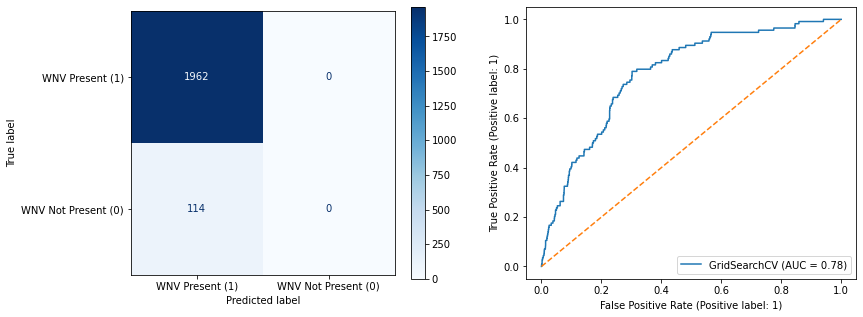

In [54]:
mod_metrics = metrics_and_plot_cm(gs_pca_logreg, X_val, y_val)

In [55]:
results_df = append_results(results_df,
                           gs_pca_svc.score(X_train, y_train),
                           mod_metrics,
                           'PCA SVM',
                           )

In [56]:
results_df

,model,train_accuracy,test_accuracy,misclassification,sensitivity,specificity,precision,f1_score,roc_auc
0,Logistic Regression,0.944926,0.944605,0.055395,0.0,0.999490,0.0,0.0,0.816471
1,SVM,0.946050,0.944123,0.055877,0.0,0.998981,0.0,0.0,0.803025
2,PCA Logistic Regression,0.944926,0.945087,0.054913,0.0,1.000000,NaN,0.0,0.783228
3,PCA SVM,0.944926,0.945087,0.054913,0.0,1.000000,NaN,0.0,0.783228


# Feature Importance

In [57]:
# note: svm on rbf has no feature importance, only svm on linear has it
# https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn

Feature Importance based on Logistic Regression

In [58]:
gs_logreg.best_estimator_[1].coef_

array([[-6.76020538e-01,  2.54791252e-01,  0.00000000e+00,
        -4.00739720e-01,  1.77219301e-01,  0.00000000e+00,
        -1.94309255e-01,  2.06572753e-01,  2.52058183e-01,
         7.99209669e-01, -2.98966931e-01,  4.42458588e-01,
        -1.75714956e-02,  0.00000000e+00, -8.68816720e-01,
        -8.44758007e-02,  0.00000000e+00,  0.00000000e+00,
        -1.16486889e-02, -5.82366257e-01,  0.00000000e+00,
         0.00000000e+00,  2.90213853e-01, -3.03735490e-01,
        -1.06594411e+00,  0.00000000e+00,  2.51637331e-01,
         0.00000000e+00, -1.24670422e+00,  1.03486875e-01,
         0.00000000e+00, -4.20726025e-01,  4.94790698e-01,
        -3.23030259e-01,  0.00000000e+00,  7.65130708e-01,
         0.00000000e+00,  5.83308171e-01,  0.00000000e+00,
        -5.81139066e-01,  0.00000000e+00,  9.23351300e-01,
         0.00000000e+00,  0.00000000e+00, -1.62315852e-01,
         2.53091237e-01,  8.21016373e-01,  1.52506590e-03,
        -1.23112346e-01,  0.00000000e+00,  8.05196792e-0

In [59]:
logreg_features = pd.DataFrame({'feature_names': X_train.columns,
                                'feature_importance': gs_logreg.best_estimator_[1].coef_[0]})

In [60]:
# top 20 features
logreg_features = logreg_features.sort_values(by='feature_importance', ascending=False).head(20)

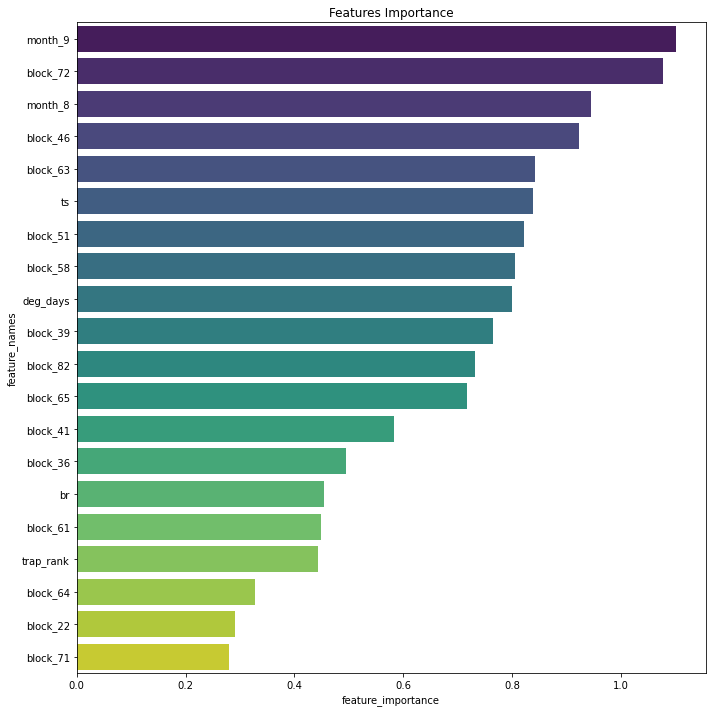

In [61]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=logreg_features, y='feature_names', x='feature_importance', palette='viridis')

plt.title('Features Importance')
plt.tight_layout()
plt.show()

# Cost Benefit Analysis

## Research

Spraying Costs


- [Time of spray](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_communities/news/2020/august/city-to-spray-insecticide-thursday-to-kill-mosquitoes.html): Weather permitting, the spraying will begin at dusk on August 13th and continue through the night until approximately 1:00 am, with licensed mosquito abatement technicians in trucks dispensing an ultra-low-volume spray. The material being used to control the adult mosquitoes, Zenivex.


- [Spray rate of Zerivex](https://chicago.cbslocal.com/2017/08/30/spray-mosquitoes-far-south-side-west-nile-prevention/): The chemical used is Zenivex, applied at a rate of 1.5 fluid ounces per acre. That measure is approved by the U.S. EPA to control mosquitoes in outdoor residential and recreational areas.


- [Zerivex cost per acre](file:///C:/Users/caspe/Downloads/Zenivex%20Cost%20Comparison%20Fact%20Sheet.pdf): USD0.67 per acre



- Area of Chicago City: esimated to be 145,300 acres based on Google Search




Based on the above, we assume the cost of spray to be USD 0.67 per acre multiplied by the area of Chicago city. This accounts for 1 spraying exercise.

In [66]:
spray_cost = 145300*0.67
spray_cost

97351.0

We assume we want to be aggresive and spray every week during the summer months of July, August and September based on our spray effectiveness analysis in the previous notebook.

In [67]:
# each spray * 4 weeks * 3 months
spray_cost * 4 * 3

1168212.0

For this scenario, we would need to set aside a budget of about USD 580,000 to conduct the spraying exercises on an annual basis.

Medical Health Costs

  - Patients who were hospitalized with acute flaccid paralysis, a partial- to whole-body paralysis caused by WNV infection, had the largest initial and long-term medical costs ([median USD 25,000 and USD 22,000 respectively](https://www.sciencedaily.com/releases/2014/02/140210184713.htm)).
  
  
  - Number of [human WNV cases](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7241786/) in Chicago region (refer to Table 2): 24 in 2011 and 66 in 2013
  
  
  - The [CDC site](https://www.cdc.gov/westnile/index.html) shares that while there are no vaccines to prevent or medications to treat WNV in people, about 1 in 5 people who are infected develop a fever and other symptoms and about 1 out of 150 infected people develop a serious, sometimes fatal, illness.  
  
  - Since only 1 in 150 people develop a serious illness which may require hospitalization, we assume that for the years 2011 and 2013, no one was hospitalized and there were no additional medical heath costs.

Based on the analysis above, there were very little benefit of the spraying in 2011 and 2013 due to the pathological nature of the WNV which we have studied so far. Furthermore, referencing back to our previous notebook on the spray data effectiveness analysis, the spray effectiveness is very sensitive to weather patterns.

# Conclusion